In [1]:
import torch as pt
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
transforms_ = transforms.Compose([
    # transforms.RandomVerticalFlip(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAdjustSharpness(sharpness_factor=0.5),
    # transforms.RandomRotation(degrees=20),
    # transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
])
trainset = datasets.FashionMNIST("./data", train=True, download=True, transform=transforms_)
testset = datasets.FashionMNIST("./data", train=False, download=True, transform=transforms_)

In [3]:
batch_size = 32

In [4]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [5]:
CLASSES = {v: k
    for k, v in trainset.class_to_idx.items()
}
CLASSES

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

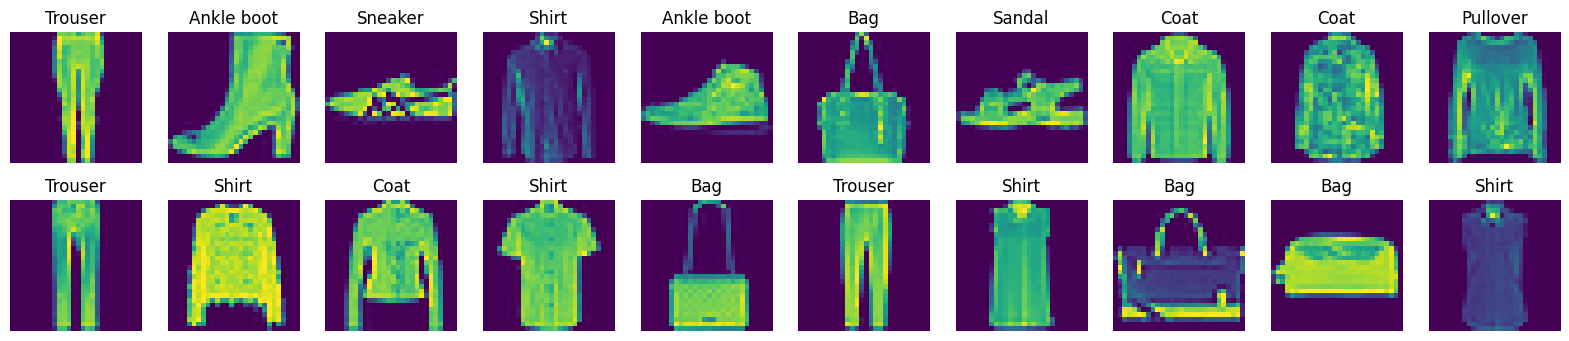

In [6]:
plt.figure(figsize=(20, 4), dpi=100)
idx = 1
images, labels = next(iter(trainloader))
for idx in range(20):
    plt.subplot(2, 10, idx+1)
    plt.imshow(images[idx].numpy()[0])
    plt.axis("off")
    plt.title(CLASSES[labels[idx].item()])
    idx += 1

In [7]:
print (f"Train dataset size: {trainset.data.size()[0]}")
print (f"Test dataset size: {testset.data.size()[0]}")

Train dataset size: 60000
Test dataset size: 10000


In [8]:
device = "cuda" if pt.cuda.is_available() else "cpu"

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # ((28-3 + 2*0) / 1) + 1 = 26, & Max Pool kernel size is 2x2  26 / 2 = 13
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
        ) # ((13-3 + 2*0) / 1) + 1 = 11
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
        ) # ((11-3 + 2*0) / 1) + 1 = 9
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(),
        ) # ((9-3 + 2*0) / 1) + 1 = 7
        self.fc1 = nn.Linear(in_features=256 * 7 * 7, out_features=1024) # (256 i.e. last layer output channel and 7 * 7 as per to the calculation)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=len(CLASSES))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(-1, 256 * 7 * 7)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.drop(out)
        out = self.fc3(out)
        return F.log_softmax(out)

In [10]:
model = Net().to(device)
optimizer = pt.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
epochs = 10

In [11]:
def criterion(pred, labels, size_average=None):
    return F.nll_loss(pred, labels, size_average=size_average)

In [12]:
def train(e):
    model.train(mode=True)
    train_loss = 0
    accuracy = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)
        pred = pred.data.max(1, keepdim=True)[1]
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        accuracy += pred.eq(labels.view_as(pred)).sum().item()
    train_loss /= len(trainloader.dataset)
    accuracy /= len(trainloader.dataset)
    print (f"Epoch: {e+1}/{epochs} Training loss: {loss.item():.6f} Training Accuracy: {accuracy:.6f}", end="; ")
    return train_loss

def test():
    model.eval()
    test_loss = 0
    test_acc = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        test_loss += criterion(pred, labels, size_average=False).item() * images.size(0)
        pred = pred.data.max(1, keepdim=True)[1]
        test_acc += pred.eq(labels.view_as(pred)).sum().item()
    test_loss /= len(testloader.dataset)
    test_acc /= len(testloader.dataset)
    print (f"Validation loss: {test_loss:.6f} Validation Accuracy: {test_acc:.6f}")
    return test_acc

In [13]:
train_loss, test_acc = list(), list()
for i in range(epochs):
    train_loss.append(train(i))
    test_acc.append(test())

/tmp/ipykernel_5234/3095955673.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Epoch: 1/10 Training loss: 0.598278 Training Accuracy: 0.750500; 

/home/parth/miniconda3/envs/env_pytorch_LTS/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Validation loss: 12.736497 Validation Accuracy: 0.856000
Epoch: 2/10 Training loss: 0.179575 Training Accuracy: 0.874200; Validation loss: 10.410222 Validation Accuracy: 0.880300
Epoch: 3/10 Training loss: 0.234668 Training Accuracy: 0.895983; Validation loss: 8.573347 Validation Accuracy: 0.899700
Epoch: 4/10 Training loss: 0.424545 Training Accuracy: 0.908950; Validation loss: 8.464267 Validation Accuracy: 0.904800
Epoch: 5/10 Training loss: 0.208976 Training Accuracy: 0.918517; Validation loss: 8.190997 Validation Accuracy: 0.906500
Epoch: 6/10 Training loss: 0.011833 Training Accuracy: 0.926867; Validation loss: 7.889549 Validation Accuracy: 0.913100
Epoch: 7/10 Training loss: 0.191836 Training Accuracy: 0.936050; Validation loss: 7.492217 Validation Accuracy: 0.916200
Epoch: 8/10 Training loss: 0.074712 Training Accuracy: 0.942450; Validation loss: 7.739681 Validation Accuracy: 0.920800
Epoch: 9/10 Training loss: 0.123161 Training Accuracy: 0.947950; Validation loss: 7.908638 Vali

Text(0.5, 1.0, 'Training Loss vs Test Accuracy')

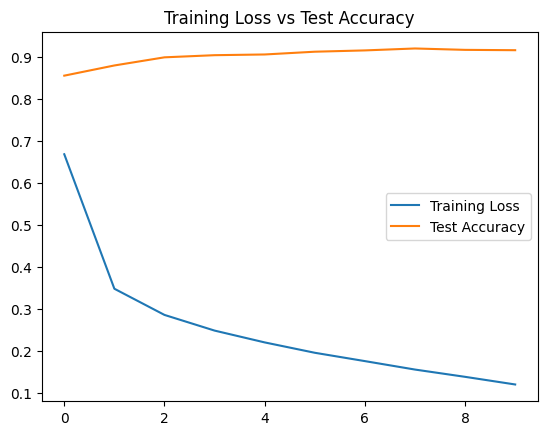

In [14]:
plt.plot(train_loss, label="Training Loss")
plt.plot(test_acc, label="Test Accuracy")
plt.legend(loc="center right")
plt.title("Training Loss vs Test Accuracy")

In [16]:
pt.save(model, "./fashion_mnist_pytorch.pt")